![Logo](https://raw.githubusercontent.com/BartaZoltan/deep-reinforcement-learning-course/main/notebooks/shared_assets/logo.png)

# Practice 2: Markov Decision Processes and Dynamic Programming

**Developers:** Zoltán Barta  
**Date:** 2026-02-17  
**Version:** 2025-26/2

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/BartaZoltan/deep-reinforcement-learning-course/blob/main/notebooks/sessions/session_02_mdp_dynamic_programming/session_02_mdp_dynamic_programming.ipynb)

This practice session follows Chapters 3-4 of *Reinforcement Learning: An Introduction (2nd ed.)* by Sutton & Barto.


## Session structure (90 minutes)

1. Build a small tabular MDP (Gridworld).
2. Implement iterative policy evaluation.
3. Implement policy iteration.
4. Implement value iteration.
5. Run quick sensitivity checks for `gamma` and `theta`.
6. Compare outputs and discuss when each method is preferable.

This notebook contains **full solutions** (in-class reference).

In [24]:
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## 1) Tabular MDP representation

We use the transition structure
`P[s][a] = [(probability, next_state, reward, done), ...]`.

For this practice, the model is fully known, so dynamic programming is directly applicable.

In [25]:
Transition = Tuple[float, int, float, bool]  # (p, s_next, reward, done)


@dataclass
class TabularMDP:
    nS: int
    nA: int
    P: List[List[List[Transition]]]
    gamma: float = 1.0

    def transitions(self, s: int, a: int) -> List[Transition]:
        return self.P[s][a]


def state_to_rc(s: int, cols: int) -> Tuple[int, int]:
    return divmod(s, cols)


def rc_to_state(r: int, c: int, cols: int) -> int:
    return r * cols + c

## 2) Build a deterministic 4x4 Gridworld

Goal: create an MDP where actions are `up/right/down/left`, with boundary clipping,
step reward `-1`, and absorbing terminal states.

We use terminals at state `0` (top-left) and state `15` (bottom-right).

In [26]:
def build_gridworld_mdp(
    rows: int = 4,
    cols: int = 4,
    terminal_states: Optional[Iterable[int]] = None,
    step_reward: float = -1.0,
    gamma: float = 1.0,
) -> Tuple[TabularMDP, List[int]]:
    nS = rows * cols
    nA = 4  # up, right, down, left

    if terminal_states is None:
        terminal_states = [0, nS - 1]
    terminal_states = list(terminal_states)
    terminal_set = set(terminal_states)

    P: List[List[List[Transition]]] = [[[] for _ in range(nA)] for _ in range(nS)]

    def move(s: int, a: int) -> int:
        r, c = state_to_rc(s, cols)
        if a == 0:      # up
            r2, c2 = max(r - 1, 0), c
        elif a == 1:    # right
            r2, c2 = r, min(c + 1, cols - 1)
        elif a == 2:    # down
            r2, c2 = min(r + 1, rows - 1), c
        elif a == 3:    # left
            r2, c2 = r, max(c - 1, 0)
        else:
            raise ValueError('Invalid action')
        return rc_to_state(r2, c2, cols)

    for s in range(nS):
        for a in range(nA):
            if s in terminal_set:
                P[s][a] = [(1.0, s, 0.0, True)]
                continue

            s2 = move(s, a)
            done = s2 in terminal_set
            P[s][a] = [(1.0, s2, step_reward, done)]

    return TabularMDP(nS=nS, nA=nA, P=P, gamma=gamma), terminal_states


grid_rows, grid_cols = 4, 4
grid_mdp, grid_terminals = build_gridworld_mdp(rows=grid_rows, cols=grid_cols, gamma=1.0)

print(f'nS={grid_mdp.nS}, nA={grid_mdp.nA}, terminals={grid_terminals}')
print('Sample transition: P[1][right] =', grid_mdp.transitions(1, 1))

nS=16, nA=4, terminals=[0, 15]
Sample transition: P[1][right] = [(1.0, 2, -1.0, False)]


In [27]:
ACTION_SYMBOLS = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}


def print_value_grid(V: np.ndarray, rows: int, cols: int, title: str = 'Value function'):
    print(title)
    print(np.array(V).reshape(rows, cols).round(2))


def greedy_policy_from_q(Q: np.ndarray, tie_break: str = 'uniform') -> np.ndarray:
    nS, nA = Q.shape
    policy = np.zeros((nS, nA), dtype=float)
    best_actions = Q == Q.max(axis=1, keepdims=True)

    if tie_break == 'uniform':
        counts = best_actions.sum(axis=1, keepdims=True)
        policy = best_actions.astype(float) / counts
    elif tie_break == 'first':
        a_star = np.argmax(Q, axis=1)
        policy[np.arange(nS), a_star] = 1.0
    else:
        raise ValueError("tie_break must be 'uniform' or 'first'")

    return policy


def print_policy_grid(policy: np.ndarray, rows: int, cols: int, terminals: List[int], title: str = 'Policy'):
    a_star = np.argmax(policy, axis=1)
    grid = np.empty(rows * cols, dtype=object)
    for s in range(rows * cols):
        grid[s] = 'T' if s in terminals else ACTION_SYMBOLS[a_star[s]]
    print(title)
    print(grid.reshape(rows, cols))

## 3) Iterative policy evaluation

Evaluate a fixed stochastic policy with repeated Bellman expectation backups:

\[
V_{k+1}(s)=\sum_a \pi(a\mid s)\sum_{s',r} p(s',r\mid s,a)\left[r+\gamma V_k(s')
ight]
\]

Stopping condition: `max_s |V_new(s)-V_old(s)| < theta`.

In [28]:
def validate_policy(policy: np.ndarray, nS: int, nA: int) -> None:
    if policy.shape != (nS, nA):
        raise ValueError(f'policy must have shape {(nS, nA)}')
    if np.any(policy < -1e-12):
        raise ValueError('policy must be non-negative')
    if not np.allclose(policy.sum(axis=1), 1.0):
        raise ValueError('each policy row must sum to 1')


def policy_evaluation(
    mdp: TabularMDP,
    policy: np.ndarray,
    theta: float = 1e-10,
    max_iterations: int = 1_000_000,
    V0: Optional[np.ndarray] = None,
    in_place: bool = True,
) -> Tuple[np.ndarray, int]:
    validate_policy(policy, mdp.nS, mdp.nA)
    V = np.zeros(mdp.nS, dtype=float) if V0 is None else V0.astype(float).copy()

    for it in range(max_iterations):
        delta = 0.0

        if in_place:
            for s in range(mdp.nS):
                v_old = V[s]
                v_new = 0.0
                for a in range(mdp.nA):
                    pi = policy[s, a]
                    if pi == 0.0:
                        continue
                    for p, s2, r, done in mdp.transitions(s, a):
                        boot = 0.0 if done else mdp.gamma * V[s2]
                        v_new += pi * p * (r + boot)
                V[s] = v_new
                delta = max(delta, abs(v_new - v_old))
        else:
            V_new = V.copy()
            for s in range(mdp.nS):
                v_new = 0.0
                for a in range(mdp.nA):
                    pi = policy[s, a]
                    if pi == 0.0:
                        continue
                    for p, s2, r, done in mdp.transitions(s, a):
                        boot = 0.0 if done else mdp.gamma * V[s2]
                        v_new += pi * p * (r + boot)
                V_new[s] = v_new
            delta = np.max(np.abs(V_new - V))
            V = V_new

        if delta < theta:
            return V, it + 1

    return V, max_iterations

In [29]:
random_policy = np.ones((grid_mdp.nS, grid_mdp.nA), dtype=float) / grid_mdp.nA
V_random, eval_iters = policy_evaluation(grid_mdp, random_policy, theta=1e-12)

print(f'Policy-evaluation sweeps: {eval_iters}')
print_value_grid(V_random, grid_rows, grid_cols, title='V^pi for uniform-random policy')

Policy-evaluation sweeps: 325
V^pi for uniform-random policy
[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


## 4) Policy iteration

Loop until stable:
1. Evaluate current policy.
2. Improve policy greedily w.r.t. `Q^pi`.
3. Stop when policy no longer changes.

In [30]:
def q_from_v(mdp: TabularMDP, V: np.ndarray) -> np.ndarray:
    Q = np.zeros((mdp.nS, mdp.nA), dtype=float)
    for s in range(mdp.nS):
        for a in range(mdp.nA):
            q = 0.0
            for p, s2, r, done in mdp.transitions(s, a):
                boot = 0.0 if done else mdp.gamma * V[s2]
                q += p * (r + boot)
            Q[s, a] = q
    return Q


def policy_iteration(
    mdp: TabularMDP,
    theta: float = 1e-10,
    max_policy_iterations: int = 10_000,
) -> Tuple[np.ndarray, np.ndarray, int, int]:
    policy = np.ones((mdp.nS, mdp.nA), dtype=float) / mdp.nA
    V = np.zeros(mdp.nS, dtype=float)
    total_eval_sweeps = 0

    for outer in range(max_policy_iterations):
        V, sweeps = policy_evaluation(mdp, policy, theta=theta, V0=V, in_place=True)
        total_eval_sweeps += sweeps

        Q = q_from_v(mdp, V)
        new_policy = greedy_policy_from_q(Q, tie_break='uniform')

        if np.allclose(new_policy, policy):
            return policy, V, outer + 1, total_eval_sweeps

        policy = new_policy

    return policy, V, max_policy_iterations, total_eval_sweeps

In [31]:
pi_star, V_star_pi, pi_outer_loops, pi_eval_sweeps = policy_iteration(grid_mdp, theta=1e-12)

print(f'Policy-iteration outer loops: {pi_outer_loops}')
print(f'Total policy-evaluation sweeps: {pi_eval_sweeps}')
print_value_grid(V_star_pi, grid_rows, grid_cols, title='V* from policy iteration')
print_policy_grid(pi_star, grid_rows, grid_cols, grid_terminals, title='Greedy policy from policy iteration')

Policy-iteration outer loops: 3
Total policy-evaluation sweeps: 329
V* from policy iteration
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]
Greedy policy from policy iteration
[['T' 'L' 'L' 'D']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'R' 'D']
 ['U' 'R' 'R' 'T']]


## 5) Value iteration

Bellman optimality backups:

\[
V_{k+1}(s)=\max_a\sum_{s',r}p(s',r\mid s,a)\left[r+\gamma V_k(s')
ight]
\]

Then extract the greedy policy from `V*`.

In [32]:
def value_iteration(
    mdp: TabularMDP,
    theta: float = 1e-10,
    max_iterations: int = 1_000_000,
) -> Tuple[np.ndarray, np.ndarray, int]:
    V = np.zeros(mdp.nS, dtype=float)

    for it in range(max_iterations):
        delta = 0.0
        for s in range(mdp.nS):
            v_old = V[s]
            q_sa = []
            for a in range(mdp.nA):
                q = 0.0
                for p, s2, r, done in mdp.transitions(s, a):
                    boot = 0.0 if done else mdp.gamma * V[s2]
                    q += p * (r + boot)
                q_sa.append(q)
            V[s] = float(np.max(q_sa))
            delta = max(delta, abs(V[s] - v_old))

        if delta < theta:
            break

    Q = q_from_v(mdp, V)
    policy = greedy_policy_from_q(Q, tie_break='uniform')
    return policy, V, it + 1

In [33]:
pi_vi, V_vi, vi_sweeps = value_iteration(grid_mdp, theta=1e-12)

print(f'Value-iteration sweeps: {vi_sweeps}')
print_value_grid(V_vi, grid_rows, grid_cols, title='V* from value iteration')
print_policy_grid(pi_vi, grid_rows, grid_cols, grid_terminals, title='Greedy policy from value iteration')
print('Are V* estimates close (PI vs VI)?', np.allclose(V_star_pi, V_vi, atol=1e-8))

Value-iteration sweeps: 4
V* from value iteration
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]
Greedy policy from value iteration
[['T' 'L' 'L' 'D']
 ['U' 'U' 'U' 'D']
 ['U' 'U' 'R' 'D']
 ['U' 'R' 'R' 'T']]
Are V* estimates close (PI vs VI)? True


## Policy-improvement visualization (how policy changes)

To make dynamic programming more intuitive, we track the policy after each improvement step and plot snapshots.

This directly answers the practical question: *how does policy iteration gradually reshape behavior?*

In [34]:
def plot_policy_value_snapshot(
    ax,
    policy: np.ndarray,
    V: np.ndarray,
    rows: int,
    cols: int,
    terminals: List[int],
    title: str,
    action_symbols: Optional[dict] = None,
):
    if action_symbols is None:
        action_symbols = ACTION_SYMBOLS

    grid_v = V.reshape(rows, cols)
    im = ax.imshow(grid_v, cmap='viridis')

    a_star = np.argmax(policy, axis=1)
    for s in range(rows * cols):
        r, c = divmod(s, cols)
        if s in terminals:
            ax.text(c, r, 'T', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        else:
            ax.text(c, r, action_symbols[a_star[s]], ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    return im


def policy_iteration_with_history(
    mdp: TabularMDP,
    rows: int,
    cols: int,
    terminals: List[int],
    theta: float = 1e-10,
    max_policy_iterations: int = 100,
):
    policy = np.ones((mdp.nS, mdp.nA), dtype=float) / mdp.nA
    V = np.zeros(mdp.nS, dtype=float)
    snapshots = [
        {
            'policy': policy.copy(),
            'V': V.copy(),
            'label': 'initial random policy',
        }
    ]
    total_eval_sweeps = 0

    for outer in range(max_policy_iterations):
        V, sweeps = policy_evaluation(mdp, policy, theta=theta, V0=V, in_place=True)
        total_eval_sweeps += sweeps

        Q = q_from_v(mdp, V)
        new_policy = greedy_policy_from_q(Q, tie_break='uniform')

        snapshots.append(
            {
                'policy': new_policy.copy(),
                'V': V.copy(),
                'label': f'after improvement {outer + 1}',
            }
        )

        if np.allclose(new_policy, policy):
            return new_policy, V, outer + 1, total_eval_sweeps, snapshots

        policy = new_policy

    return policy, V, max_policy_iterations, total_eval_sweeps, snapshots

Policy iteration outer loops: 3
Total evaluation sweeps: 329
Snapshots captured: 4


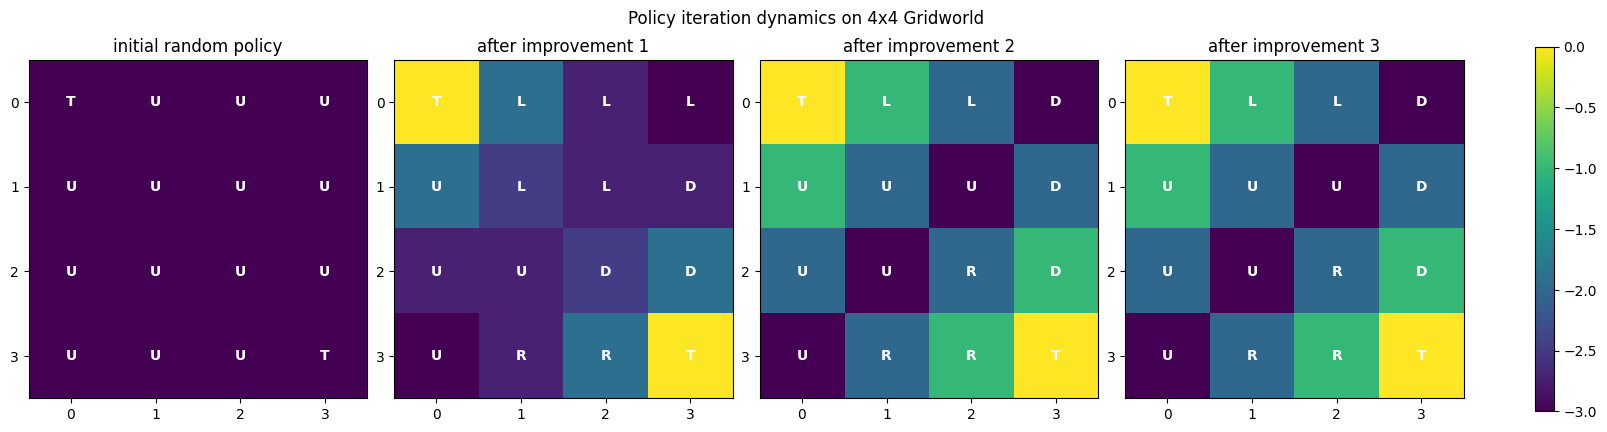

In [35]:
pi_vis, V_vis, vis_outer_loops, vis_eval_sweeps, snapshots = policy_iteration_with_history(
    grid_mdp,
    rows=grid_rows,
    cols=grid_cols,
    terminals=grid_terminals,
    theta=1e-12,
)

print(f'Policy iteration outer loops: {vis_outer_loops}')
print(f'Total evaluation sweeps: {vis_eval_sweeps}')
print(f'Snapshots captured: {len(snapshots)}')

# Plot a few meaningful checkpoints
idx_candidates = [0, 1, len(snapshots) // 2, len(snapshots) - 1]
idxs = []
for i in idx_candidates:
    if 0 <= i < len(snapshots) and i not in idxs:
        idxs.append(i)

fig, axes = plt.subplots(1, len(idxs), figsize=(4 * len(idxs), 4), constrained_layout=True)
if len(idxs) == 1:
    axes = [axes]

im = None
for ax, idx in zip(axes, idxs):
    snap = snapshots[idx]
    im = plot_policy_value_snapshot(
        ax=ax,
        policy=snap['policy'],
        V=snap['V'],
        rows=grid_rows,
        cols=grid_cols,
        terminals=grid_terminals,
        title=snap['label'],
    )

if im is not None:
    fig.colorbar(im, ax=axes, fraction=0.025)
plt.suptitle('Policy iteration dynamics on 4x4 Gridworld', y=1.05)
plt.show()

## Gymnasium example with Dynamic Programming: FrozenLake-v1

A practical Gymnasium example that fits DP perfectly is **FrozenLake** because Gymnasium exposes the transition model `env.unwrapped.P`.

That means we can do *planning* (policy/value iteration) directly, then test the greedy policy by rollout.

In [36]:
import os

# Workaround for environments where plugin auto-registration (shimmy/ale) breaks gymnasium import.
os.environ.setdefault('GYM_DISABLE_ENV_PLUGINS', '1')

try:
    import gymnasium as gym
    _GYM_IMPORT_ERROR = None
except Exception as e:  # not only ImportError: handle circular/plugin init failures too
    gym = None
    _GYM_IMPORT_ERROR = e
    print('Gymnasium could not be imported in this environment.')
    print(f'Import error: {type(e).__name__}: {e}')
    print('Suggested fix in your drl env: pip install -U "gymnasium>=0.29.1,<1.0" shimmy ale-py')


FROZEN_ACTION_SYMBOLS = {0: 'L', 1: 'D', 2: 'R', 3: 'U'}


def frozenlake_to_mdp(is_slippery: bool = False, gamma: float = 0.99):
    if gym is None:
        raise RuntimeError(f'Gymnasium unavailable: {_GYM_IMPORT_ERROR}')

    env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
    P_env = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n

    P = [[[] for _ in range(nA)] for _ in range(nS)]
    for s in range(nS):
        for a in range(nA):
            trans = []
            for prob, s2, reward, done in P_env[s][a]:
                trans.append((float(prob), int(s2), float(reward), bool(done)))
            P[s][a] = trans

    desc = env.unwrapped.desc.astype(str)
    env.close()
    return TabularMDP(nS=nS, nA=nA, P=P, gamma=gamma), desc


def frozenlake_terminal_states(desc: np.ndarray) -> List[int]:
    rows, cols = desc.shape
    terminals = []
    for r in range(rows):
        for c in range(cols):
            if desc[r, c] in {'H', 'G'}:
                terminals.append(r * cols + c)
    return terminals


def plot_frozenlake_policy(desc: np.ndarray, policy: np.ndarray, V: np.ndarray, title: str):
    rows, cols = desc.shape
    terminals = set(frozenlake_terminal_states(desc))

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(V.reshape(rows, cols), cmap='Blues')

    a_star = np.argmax(policy, axis=1)
    for r in range(rows):
        for c in range(cols):
            s = r * cols + c
            cell = desc[r, c]
            if cell == 'H':
                txt = 'H'
            elif cell == 'G':
                txt = 'G'
            elif cell == 'S':
                txt = 'S'
            else:
                txt = FROZEN_ACTION_SYMBOLS[a_star[s]] if s not in terminals else 'T'
            ax.text(c, r, txt, ha='center', va='center', color='black', fontsize=11, fontweight='bold')

    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    fig.colorbar(im, ax=ax, fraction=0.046)
    plt.show()


def render_frozenlake_state(desc: np.ndarray, state: int, title: str = ''):
    rows, cols = desc.shape
    r, c = divmod(state, cols)

    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    bg = np.zeros((rows, cols), dtype=float)
    bg[r, c] = 1.0
    ax.imshow(bg, cmap='YlOrRd', vmin=0.0, vmax=1.0)

    for rr in range(rows):
        for cc in range(cols):
            cell = desc[rr, cc]
            ax.text(cc, rr, cell, ha='center', va='center', color='black', fontsize=12, fontweight='bold')

    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.4)
    plt.show()



FrozenLake (non-slippery) value-iteration sweeps: 7


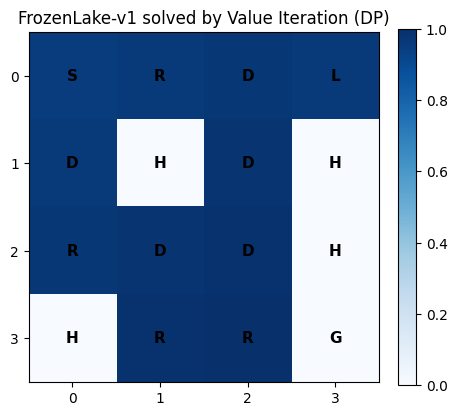

In [37]:
if gym is not None:
    fl_mdp, fl_desc = frozenlake_to_mdp(is_slippery=False, gamma=0.99)
    fl_pi, fl_V, fl_iters = value_iteration(fl_mdp, theta=1e-12)

    print(f'FrozenLake (non-slippery) value-iteration sweeps: {fl_iters}')
    plot_frozenlake_policy(
        desc=fl_desc,
        policy=fl_pi,
        V=fl_V,
        title='FrozenLake-v1 solved by Value Iteration (DP)'
    )

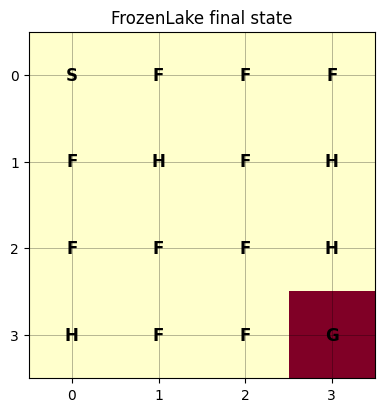

In [38]:
if gym is not None:
    import time
    from IPython.display import clear_output

    env = gym.make('FrozenLake-v1', is_slippery=False)
    obs, _ = env.reset(seed=42)
    done = False
    trajectory = [obs]
    total_reward = 0.0

    while not done:
        action = int(np.argmax(fl_pi[obs]))
        obs, reward, terminated, truncated, _ = env.step(action)
        trajectory.append(obs)
        total_reward += reward
        done = terminated or truncated

    env.close()

    print('Greedy rollout states:', trajectory)
    print('Total reward:', total_reward)

    # Simple in-notebook animation of the board progression
    for t, s in enumerate(trajectory):
        clear_output(wait=True)
        render_frozenlake_state(fl_desc, s, title=f'FrozenLake trajectory step {t}/{len(trajectory)-1}')
        time.sleep(0.55)

    clear_output(wait=True)
    render_frozenlake_state(fl_desc, trajectory[-1], title='FrozenLake final state')
else:
    print('Skipping FrozenLake rollout animation because gymnasium is unavailable.')



## Visual playground: custom Gridworld maps and animation

This section salvages the most useful idea from the extra Gridworld materials: **highly visual policy dynamics**.

We add:
- animated policy-iteration snapshots,
- a custom-map Gridworld constructor (`S`, `.`, `#`, `H`, `G`),
- direct visual checks of `V*` and greedy policy on richer layouts.

Saved: assets/session_02_policy_iteration.gif


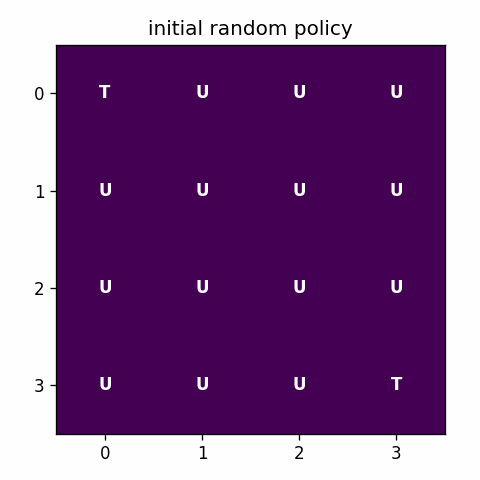

In [39]:
from pathlib import Path

from IPython.display import Image as IPyImage, display
from PIL import Image


def save_policy_iteration_gif(
    snapshots,
    rows,
    cols,
    terminals,
    out_path='assets/session_02_policy_iteration.gif',
    duration_ms=700,
):
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    frame_files = []
    for k, snap in enumerate(snapshots):
        fig, ax = plt.subplots(figsize=(4, 4))
        plot_policy_value_snapshot(
            ax=ax,
            policy=snap['policy'],
            V=snap['V'],
            rows=rows,
            cols=cols,
            terminals=terminals,
            title=snap['label'],
        )
        fig.tight_layout()
        tmp = out_path.parent / f'_tmp_frame_{k:03d}.png'
        fig.savefig(tmp, dpi=120)
        plt.close(fig)
        frame_files.append(tmp)

    frames = [Image.open(fp) for fp in frame_files]
    if frames:
        frames[0].save(
            out_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration_ms,
            loop=0,
        )

    for fr in frames:
        fr.close()
    for fp in frame_files:
        fp.unlink(missing_ok=True)

    return out_path


gif_path = save_policy_iteration_gif(
    snapshots=snapshots,
    rows=grid_rows,
    cols=grid_cols,
    terminals=grid_terminals,
)
print('Saved:', gif_path)
display(IPyImage(filename=str(gif_path)))

In [40]:
def build_gridworld_from_char_map(
    char_map,
    gamma=0.99,
    step_reward=-0.02,
    goal_reward=1.0,
    hole_reward=-1.0,
):
    # Symbols: 'S' start, '.' free, '#' wall, 'H' hole, 'G' goal
    grid = np.array([list(row) for row in char_map])
    rows, cols = grid.shape
    nS, nA = rows * cols, 4

    def sidx(r, c):
        return r * cols + c

    def in_bounds(r, c):
        return 0 <= r < rows and 0 <= c < cols

    terminal_states = []
    walls = set()
    for r in range(rows):
        for c in range(cols):
            cell = grid[r, c]
            s = sidx(r, c)
            if cell in {'H', 'G'}:
                terminal_states.append(s)
            if cell == '#':
                walls.add(s)

    P = [[[] for _ in range(nA)] for _ in range(nS)]
    offsets = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}

    for r in range(rows):
        for c in range(cols):
            s = sidx(r, c)
            cell = grid[r, c]
            for a in range(nA):
                if s in walls:
                    P[s][a] = [(1.0, s, 0.0, True)]
                    continue

                if cell in {'H', 'G'}:
                    P[s][a] = [(1.0, s, 0.0, True)]
                    continue

                dr, dc = offsets[a]
                nr, nc = r + dr, c + dc
                if not in_bounds(nr, nc):
                    nr, nc = r, c
                ns = sidx(nr, nc)

                if ns in walls:
                    ns = s
                    nr, nc = r, c

                next_cell = grid[nr, nc]
                if next_cell == 'G':
                    reward, done = goal_reward, True
                elif next_cell == 'H':
                    reward, done = hole_reward, True
                else:
                    reward, done = step_reward, False

                P[s][a] = [(1.0, ns, reward, done)]

    return TabularMDP(nS=nS, nA=nA, P=P, gamma=gamma), grid, terminal_states, walls


def plot_custom_map_policy(grid_chars, policy, V, walls, title='Custom map policy and value'):
    rows, cols = grid_chars.shape
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(V.reshape(rows, cols), cmap='magma')

    a_star = np.argmax(policy, axis=1)
    for r in range(rows):
        for c in range(cols):
            s = r * cols + c
            cell = grid_chars[r, c]
            if s in walls:
                txt = '#'
            elif cell == 'G':
                txt = 'G'
            elif cell == 'H':
                txt = 'H'
            elif cell == 'S':
                txt = 'S'
            else:
                txt = ACTION_SYMBOLS[a_star[s]]
            ax.text(c, r, txt, ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    ax.set_title(title)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    fig.colorbar(im, ax=ax, fraction=0.046)
    plt.show()

Custom map value-iteration sweeps: 6


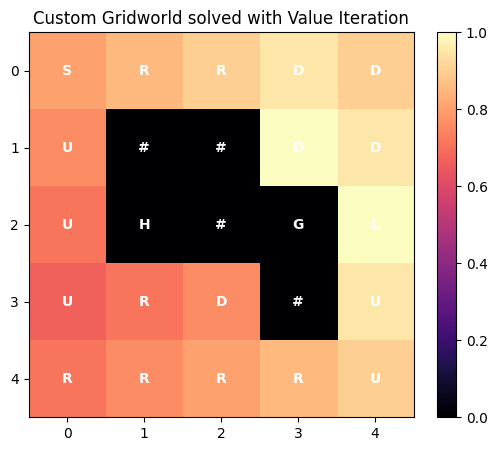

In [41]:
char_map = [
    'S....',
    '.##..',
    '.H#G.',
    '...#.',
    '.....',
]

custom_mdp, custom_grid, custom_terminals, custom_walls = build_gridworld_from_char_map(
    char_map,
    gamma=0.98,
    step_reward=-0.03,
)

custom_pi, custom_V, custom_iters = value_iteration(custom_mdp, theta=1e-10)
print('Custom map value-iteration sweeps:', custom_iters)
plot_custom_map_policy(
    grid_chars=custom_grid,
    policy=custom_pi,
    V=custom_V,
    walls=custom_walls,
    title='Custom Gridworld solved with Value Iteration',
)

## Task bank (extended)

Use this as a large pool; you can pick subsets in class.

1. **Policy dynamics task**: explain why the first 2-3 policy-iteration updates change the most states.
2. **Tie-breaking task**: switch greedy tie-break from uniform to first-action and compare resulting policies.
3. **Asynchronous vs synchronous**: compare `in_place=True/False` in policy evaluation and plot convergence speed.
4. **Discount-factor effects**: run `gamma={0.8,0.9,0.99,1.0}` and discuss how far-sightedness changes behavior.
5. **Tolerance effects**: run `theta={1e-2,1e-6,1e-12}` and measure sweeps + value error.
6. **Stochastic control**: use slip dynamics and compare deterministic vs stochastic optimal policy maps.
7. **Custom-map design**: create your own `char_map` with walls/holes and justify the resulting optimal policy.
8. **Reward shaping**: vary `step_reward` and study shortest-path vs safer-path trade-offs.
9. **FrozenLake transfer**: compare DP policy from non-slippery vs slippery `FrozenLake-v1`.
10. **Model mismatch discussion**: if transitions are estimated from data (not exact), what breaks first in DP?
11. **Homework candidate**: run `session_02_jacks_car_rental.ipynb` and report runtime/parameter trade-offs.
12. **Challenge**: implement modified policy iteration and benchmark against policy iteration/value iteration.

### Suggested deliverable format

- 1 page summary (what changed, why)
- 2-4 plots (value map, policy map, convergence)
- short conclusion (which method/setting is best and under what criterion)

## 6) Quick sensitivity checks: `gamma` and `theta`

This is useful for in-class discussion:
- How does `gamma` change the scale and shape of `V*`?
- How does `theta` trade off speed vs numerical precision?

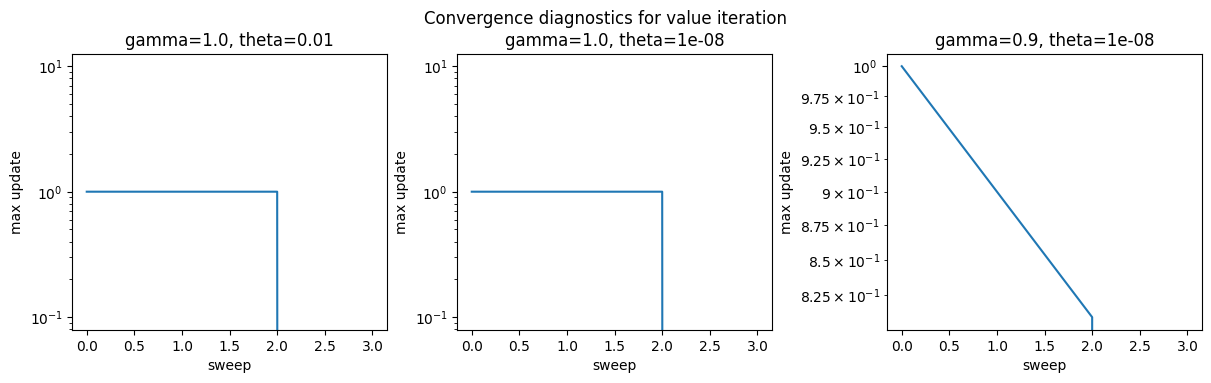

gamma=1.0, theta=0.01, sweeps=4, V*(1)=-1.000
gamma=1.0, theta=1e-08, sweeps=4, V*(1)=-1.000
gamma=0.9, theta=1e-08, sweeps=4, V*(1)=-1.000


In [42]:
def value_iteration_with_deltas(
    mdp: TabularMDP,
    theta: float = 1e-10,
    max_iterations: int = 1_000_000,
):
    V = np.zeros(mdp.nS, dtype=float)
    deltas = []

    for _ in range(max_iterations):
        delta = 0.0
        for s in range(mdp.nS):
            v_old = V[s]
            q_sa = []
            for a in range(mdp.nA):
                q = 0.0
                for p, s2, r, done in mdp.transitions(s, a):
                    boot = 0.0 if done else mdp.gamma * V[s2]
                    q += p * (r + boot)
                q_sa.append(q)
            V[s] = float(np.max(q_sa))
            delta = max(delta, abs(V[s] - v_old))
        deltas.append(delta)
        if delta < theta:
            break

    Q = q_from_v(mdp, V)
    pi = greedy_policy_from_q(Q, tie_break='uniform')
    return pi, V, np.array(deltas)


settings = [
    {'gamma': 1.0, 'theta': 1e-2},
    {'gamma': 1.0, 'theta': 1e-8},
    {'gamma': 0.9, 'theta': 1e-8},
]

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)

for ax, cfg in zip(axes, settings):
    mdp_cfg, _ = build_gridworld_mdp(rows=4, cols=4, gamma=cfg['gamma'])
    _, V_cfg, deltas_cfg = value_iteration_with_deltas(mdp_cfg, theta=cfg['theta'])
    ax.plot(deltas_cfg)
    ax.set_yscale('log')
    ax.set_title(f"gamma={cfg['gamma']}, theta={cfg['theta']}")
    ax.set_xlabel('sweep')
    ax.set_ylabel('max update')

plt.suptitle('Convergence diagnostics for value iteration', y=1.05)
plt.show()

for cfg in settings:
    mdp_cfg, _ = build_gridworld_mdp(rows=4, cols=4, gamma=cfg['gamma'])
    _, V_cfg, deltas_cfg = value_iteration_with_deltas(mdp_cfg, theta=cfg['theta'])
    print(f"gamma={cfg['gamma']}, theta={cfg['theta']}, sweeps={len(deltas_cfg)}, V*(1)={V_cfg[1]:.3f}")

## Optional extension in this session

If there is extra time, ask students to modify one item and re-run:
1. Change terminal states.
2. Add action stochasticity (slip probability).
3. Compare in-place vs synchronous policy evaluation.

You can also continue with:
- `session_02_mdp_dynamic_programming_experiments.ipynb` (extra DP experiments)
- `2. MDP/gymnasium_basics.ipynb` (Gymnasium environment basics)

## References

- Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.). http://incompleteideas.net/book/the-book-2nd.html

## 7) Extended experiments (merged from previous experiments notebook)

These are optional in-class extensions or post-class explorations.
They help students connect algorithm behavior to modeling choices.

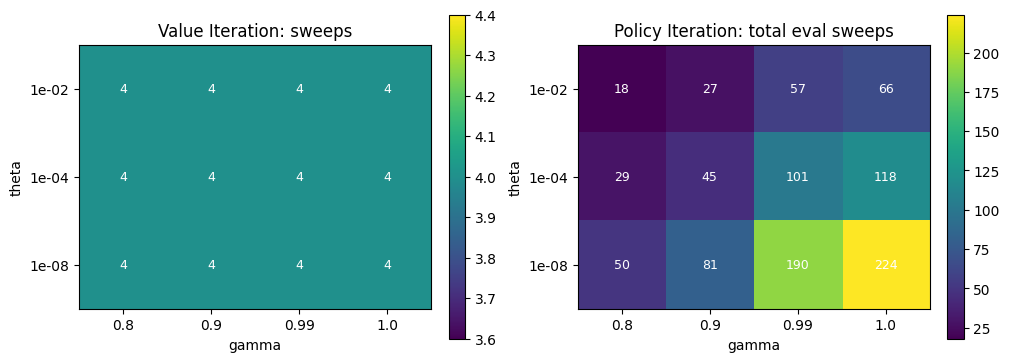

In [43]:
# Experiment A: gamma/theta sweep and iteration counts

gammas = [0.8, 0.9, 0.99, 1.0]
thetas = [1e-2, 1e-4, 1e-8]

vi_sweeps = np.zeros((len(thetas), len(gammas)), dtype=int)
pi_eval_sweeps = np.zeros((len(thetas), len(gammas)), dtype=int)

for i, theta in enumerate(thetas):
    for j, gamma in enumerate(gammas):
        mdp_cfg, _ = build_gridworld_mdp(rows=4, cols=4, gamma=gamma)
        _, _, vi_iters = value_iteration(mdp_cfg, theta=theta)
        _, _, _, pi_eval_iters = policy_iteration(mdp_cfg, theta=theta)
        vi_sweeps[i, j] = vi_iters
        pi_eval_sweeps[i, j] = pi_eval_iters

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for ax, mat, title in zip(
    axes,
    [vi_sweeps, pi_eval_sweeps],
    ['Value Iteration: sweeps', 'Policy Iteration: total eval sweeps'],
):
    im = ax.imshow(mat, cmap='viridis')
    ax.set_xticks(range(len(gammas)), [str(g) for g in gammas])
    ax.set_yticks(range(len(thetas)), [f'{t:.0e}' for t in thetas])
    ax.set_xlabel('gamma')
    ax.set_ylabel('theta')
    ax.set_title(title)
    for r in range(mat.shape[0]):
        for c in range(mat.shape[1]):
            ax.text(c, r, str(mat[r, c]), ha='center', va='center', color='white', fontsize=9)
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.show()

In [44]:
# Experiment B: larger deterministic grids

for size in [4, 5, 6, 8]:
    mdp_big, terminals_big = build_gridworld_mdp(rows=size, cols=size, gamma=1.0)
    _, V_big, vi_iters_big = value_iteration(mdp_big, theta=1e-8)
    print(f'{size}x{size} grid -> value-iteration sweeps: {vi_iters_big}, V(start+1)={V_big[1]:.3f}')

4x4 grid -> value-iteration sweeps: 4, V(start+1)=-1.000
5x5 grid -> value-iteration sweeps: 5, V(start+1)=-1.000
6x6 grid -> value-iteration sweeps: 6, V(start+1)=-1.000
8x8 grid -> value-iteration sweeps: 8, V(start+1)=-1.000


In [45]:
# Experiment C: stochastic transitions (slip dynamics)

def build_gridworld_mdp_slip(
    rows: int = 4,
    cols: int = 4,
    terminal_states: Optional[Iterable[int]] = None,
    step_reward: float = -1.0,
    gamma: float = 1.0,
    slip_epsilon: float = 0.2,
) -> Tuple[TabularMDP, List[int]]:
    if not (0.0 <= slip_epsilon <= 1.0):
        raise ValueError('slip_epsilon must be in [0,1]')

    nS = rows * cols
    nA = 4

    if terminal_states is None:
        terminal_states = [0, nS - 1]
    terminal_states = list(terminal_states)
    terminal_set = set(terminal_states)

    P: List[List[List[Transition]]] = [[[] for _ in range(nA)] for _ in range(nS)]

    def move(s: int, a: int) -> int:
        r, c = state_to_rc(s, cols)
        if a == 0:
            r2, c2 = max(r - 1, 0), c
        elif a == 1:
            r2, c2 = r, min(c + 1, cols - 1)
        elif a == 2:
            r2, c2 = min(r + 1, rows - 1), c
        elif a == 3:
            r2, c2 = r, max(c - 1, 0)
        else:
            raise ValueError('Invalid action')
        return rc_to_state(r2, c2, cols)

    for s in range(nS):
        for a in range(nA):
            if s in terminal_set:
                P[s][a] = [(1.0, s, 0.0, True)]
                continue

            probs = {}
            intended = move(s, a)
            done_intended = intended in terminal_set
            probs[(intended, step_reward, done_intended)] = probs.get((intended, step_reward, done_intended), 0.0) + (1.0 - slip_epsilon)

            others = [aa for aa in range(nA) if aa != a]
            p_other = slip_epsilon / len(others)
            for aa in others:
                s2 = move(s, aa)
                done = s2 in terminal_set
                probs[(s2, step_reward, done)] = probs.get((s2, step_reward, done), 0.0) + p_other

            P[s][a] = [(p, s2, r, done) for (s2, r, done), p in probs.items()]

    return TabularMDP(nS=nS, nA=nA, P=P, gamma=gamma), terminal_states


slip_mdp, slip_terminals = build_gridworld_mdp_slip(slip_epsilon=0.2)
pi_slip, V_slip, n_slip = value_iteration(slip_mdp, theta=1e-10)

print(f'Slippery grid value-iteration sweeps: {n_slip}')
print_value_grid(V_slip, 4, 4, title='V* on slippery grid (epsilon=0.2)')
print_policy_grid(pi_slip, 4, 4, slip_terminals, title='Greedy policy on slippery grid')

Slippery grid value-iteration sweeps: 25
V* on slippery grid (epsilon=0.2)
[[ 0.   -1.48 -2.9  -4.05]
 [-1.48 -2.79 -3.8  -2.9 ]
 [-2.9  -3.8  -2.79 -1.48]
 [-4.05 -2.9  -1.48  0.  ]]
Greedy policy on slippery grid
[['T' 'L' 'L' 'L']
 ['U' 'U' 'L' 'D']
 ['U' 'U' 'R' 'D']
 ['U' 'R' 'R' 'T']]


In [46]:
# Experiment D: FrozenLake-like variant with holes

def build_gridworld_with_holes(
    rows: int = 4,
    cols: int = 4,
    goal_state: int = 15,
    hole_states: Optional[Iterable[int]] = None,
    gamma: float = 0.99,
    step_reward: float = -0.01,
    goal_reward: float = 1.0,
    hole_reward: float = -1.0,
) -> Tuple[TabularMDP, List[int]]:
    nS = rows * cols
    nA = 4
    hole_states = list(hole_states or [5, 7, 11, 12])
    terminals = set(hole_states + [goal_state])

    P: List[List[List[Transition]]] = [[[] for _ in range(nA)] for _ in range(nS)]

    def move(s: int, a: int) -> int:
        r, c = state_to_rc(s, cols)
        if a == 0:
            r2, c2 = max(r - 1, 0), c
        elif a == 1:
            r2, c2 = r, min(c + 1, cols - 1)
        elif a == 2:
            r2, c2 = min(r + 1, rows - 1), c
        elif a == 3:
            r2, c2 = r, max(c - 1, 0)
        else:
            raise ValueError('Invalid action')
        return rc_to_state(r2, c2, cols)

    for s in range(nS):
        for a in range(nA):
            if s in terminals:
                P[s][a] = [(1.0, s, 0.0, True)]
                continue

            s2 = move(s, a)
            if s2 == goal_state:
                P[s][a] = [(1.0, s2, goal_reward, True)]
            elif s2 in hole_states:
                P[s][a] = [(1.0, s2, hole_reward, True)]
            else:
                P[s][a] = [(1.0, s2, step_reward, False)]

    return TabularMDP(nS=nS, nA=nA, P=P, gamma=gamma), sorted(terminals)


frozen_mdp, frozen_terminals = build_gridworld_with_holes()
pi_frozen, V_frozen, n_frozen = value_iteration(frozen_mdp, theta=1e-10)
print(f'FrozenLake-like grid value-iteration sweeps: {n_frozen}')
print_value_grid(V_frozen, 4, 4, title='V* for FrozenLake-like grid')
print_policy_grid(pi_frozen, 4, 4, frozen_terminals, title='Greedy policy for FrozenLake-like grid')

FrozenLake-like grid value-iteration sweeps: 7
V* for FrozenLake-like grid
[[0.9  0.92 0.94 0.92]
 [0.92 0.   0.96 0.  ]
 [0.94 0.96 0.98 0.  ]
 [0.   0.98 1.   0.  ]]
Greedy policy for FrozenLake-like grid
[['R' 'R' 'D' 'L']
 ['D' 'T' 'D' 'T']
 ['R' 'R' 'D' 'T']
 ['T' 'R' 'R' 'T']]


## 8) Supplementary notebooks in Session 2

- `session_02_gymnasium_basics.ipynb`
- `session_02_gamblers_problem.ipynb` and `session_02_gamblers_problem_empty.ipynb`
- `session_02_jacks_car_rental.ipynb` (recommended as homework)

These are now part of the session-2 root folder with unified naming and headers.